# Data preprocessing

## (1)Import credit data

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib
pd.set_option('expand_frame_repr', False) 

df = pd.read_csv(
    r'C:\Users\Desktop\Credit Risk ML Model\Credit_Data.csv',
    encoding='utf8',
)
print(df)

       person_age  person_income person_home_ownership  person_emp_length      loan_intent loan_grade  loan_amnt  loan_int_rate  loan_status  loan_percent_income cb_person_default_on_file  cb_person_cred_hist_length
0              22          59000                  RENT              123.0         PERSONAL          D      35000          16.02            1                 0.59                         Y                           3
1              21           9600                   OWN                5.0        EDUCATION          B       1000          11.14            0                 0.10                         N                           2
2              25           9600              MORTGAGE                1.0          MEDICAL          C       5500          12.87            1                 0.57                         N                           3
3              23          65500                  RENT                4.0          MEDICAL          C      35000          15.23         

## (2)Visualizing and clean abnormal data

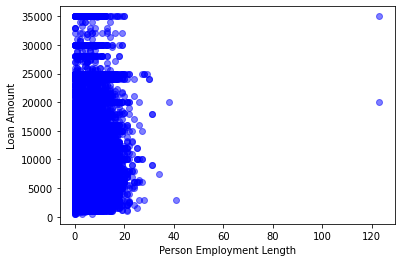

In [2]:
# ==> Create the scatter plot for employment length and amount
plt.scatter(df['person_emp_length'], df['loan_amnt'], c='blue', alpha=0.5)
plt.xlabel("Person Employment Length")
plt.ylabel("Loan Amount")
plt.show()

In [3]:
# Outliers: It may not be possible for a person to have an employment length of greater than 60.

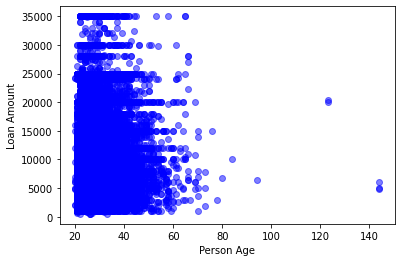

In [4]:
# ==> Create the scatter plot for age and amount
plt.scatter(df['person_age'], df['loan_amnt'], c='blue', alpha=0.5)
plt.xlabel("Person Age")
plt.ylabel("Loan Amount")
plt.show()

In [5]:
# Outliers: It may not be possible for a person to have an age of greater than 100.

### Clean abnormal data

In [6]:
# ==> Create an array of indices where employment length is greater than 60
indice1 = df[df['person_emp_length'] > 60].index
# ==> Drop the records from the data based on the indices and create a new dataframe
df_01 = df.drop(indice1)
print(df_01.shape)

# ==> Create an array of indices where employment length is greater than 60
indice2 = df_01[df_01['person_age'] > 100].index
# ==> Drop the records from the data based on the indices and create a new dataframe
df = df_01.drop(indice2)
print(df.shape)

(32579, 12)
(32574, 12)


## (3) processing missing (NaN) data

In [7]:
# Print the number of nulls
null_columns = df.columns[df.isnull().any()]
print(df[null_columns].isnull().sum())

person_emp_length     895
loan_int_rate        3115
dtype: int64


In [8]:
# Replace the null values with the median value for all employment lengths
df['person_emp_length'].fillna((df['person_emp_length'].median()), inplace=True)

In [9]:
# Store the array on indices. Create an array of indices for rows that contain missing interest rate called indices.
indices = df[df['loan_int_rate'].isnull()].index

# Save the new data without missing data. Drop the records with missing interest rate data and save the results to cr_loan_clean.
df = df.drop(indices)
print(df.shape)

(29459, 12)


## (4) One-hot encoding credit data

In [10]:
# Create two data sets for numeric and non-numeric data
cred_num = df.select_dtypes(exclude=['object'])
cred_str = df.select_dtypes(include=['object'])

# One-hot encode the non-numeric columns
cred_str_onehot = pd.get_dummies(cred_str)

# Union the one-hot encoded columns to the numeric ones
df_clean = pd.concat([cred_num, cred_str_onehot], axis=1)

# Print the columns in the new data set
print(df_clean)

       person_age  person_income  person_emp_length  loan_amnt  loan_int_rate  loan_status  loan_percent_income  cb_person_cred_hist_length  person_home_ownership_MORTGAGE  person_home_ownership_OTHER  ...  loan_intent_VENTURE  loan_grade_A  loan_grade_B  loan_grade_C  loan_grade_D  loan_grade_E  loan_grade_F  loan_grade_G  cb_person_default_on_file_N  cb_person_default_on_file_Y
1              21           9600                5.0       1000          11.14            0                 0.10                           2                               0                            0  ...                    0             0             1             0             0             0             0             0                            1                            0
2              25           9600                1.0       5500          12.87            1                 0.57                           3                               1                            0  ...                    0        

# Logistic Regression model for Defaults

### (1) Train the logistic regression model

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# Create the X and y data sets
X = df_clean.drop('loan_status', axis = 1)
y = df_clean[['loan_status']]

# Use test_train_split to create the training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4, random_state=123)

# Train the logistic regression model on the training data
clf_logistic = LogisticRegression(solver='lbfgs').fit(X_train, np.ravel(y_train))

### (2) Make predictions for defaults

In [12]:
# Create predictions of probability for loan status using test data
preds = clf_logistic.predict_proba(X_test)
print(preds)

[[0.5542214  0.4457786 ]
 [0.77655347 0.22344653]
 [0.71144174 0.28855826]
 ...
 [0.47755049 0.52244951]
 [0.6295219  0.3704781 ]
 [0.87621446 0.12378554]]


### Plot the ROC curve of the probabilities of default

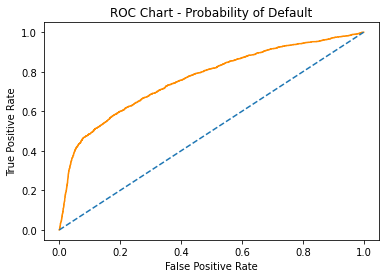

In [13]:
from sklearn.metrics import roc_curve,roc_auc_score

# Plot the ROC curve of the probabilities of default
prob_default = preds[:, 1]
fallout, sensitivity, thresholds = roc_curve(y_test, prob_default)
plt.plot(fallout, sensitivity, color = 'darkorange')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.title('ROC Chart - Probability of Default')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

### (3) Logistic regression model performance analysis

### Model performance

In [14]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

# Create dataframes of first five predictions, and first five true labels
preds_df = pd.DataFrame(preds[:, 1][0:5], columns=['prob_default'])
# Create a dataframe for the probabilities of default
preds_df = pd.DataFrame(preds[:,1], columns = ['prob_default'])
# Reassign loan status based on the threshold
preds_df['loan_status'] = preds_df['prob_default'].apply(lambda x: 1 if x > 0.5 else 0)

# Print the classification report
target_names = ['Non-Default', 'Default']
print(classification_report(y_test, preds_df['loan_status'], target_names=target_names))
# Print the weighted f1 score of the model
clf_f1 = f1_score(y_test, preds_df['loan_status'], average='weighted')
print ("The weighted f1 score of the clf model is:  {}".format(clf_f1) )
# Print the accuracy score the model
clf_score = clf_logistic.score(X_test, y_test)
print ("The accuracy score of the clf model is:  {}".format(clf_score) )

              precision    recall  f1-score   support

 Non-Default       0.81      0.98      0.89      9198
     Default       0.71      0.17      0.27      2586

    accuracy                           0.80     11784
   macro avg       0.76      0.57      0.58     11784
weighted avg       0.79      0.80      0.75     11784

The weighted f1 score of the clf model is:  0.751014639150558
The accuracy score of the clf model is:  0.8025288526816021


# Gradient Boosted Trees with XGBoost

## Load and split data

In [25]:
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')
pd.set_option('expand_frame_repr', False)  # to display a lot of columns

# ==== load data
df = pd.read_csv(
    r'C:\Users\c1571443\Credit Risk ML Model\Credit_Data.csv',
    encoding='utf8',
)
print (df.head(3))

# Create the X and y data sets
X = df.drop('loan_status', axis=1)
y = df[['loan_status']]

# Use test_train_split to create the training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4, random_state=123)

   person_age  person_income  person_emp_length  loan_amnt  loan_int_rate  loan_status  loan_percent_income  cb_person_cred_hist_length  person_home_ownership_MORTGAGE  person_home_ownership_OTHER  ...  loan_intent_VENTURE  loan_grade_A  loan_grade_B  loan_grade_C  loan_grade_D  loan_grade_E  loan_grade_F  loan_grade_G  cb_person_default_on_file_N  cb_person_default_on_file_Y
0          21           9600                  5       1000          11.14            0                 0.10                           2                               0                            0  ...                    0             0             1             0             0             0             0             0                            1                            0
1          25           9600                  1       5500          12.87            1                 0.57                           3                               1                            0  ...                    0             0      

## Train the XGBoost Model

In [22]:
# Train a model
clf_gbt = xgb.XGBClassifier().fit(X_train, np.ravel(y_train))

[15:28:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


## Predict the default

In [23]:
# Predict with a model
gbt_preds = clf_gbt.predict_proba(X_test)

# Create dataframes of first five predictions, and first five true labels
preds_df = pd.DataFrame(gbt_preds[:,1][0:5], columns = ['prob_default'])
true_df = y_test.head(5)

# Concatenate and print the two data frames for comparison
print(pd.concat([true_df.reset_index(drop = True), preds_df], axis = 1))

   loan_status  prob_default
0            1      0.990942
1            1      0.983987
2            0      0.000807
3            0      0.001239
4            1      0.084892


## Feature importance and model performance

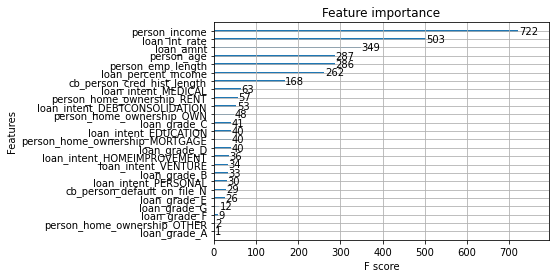

In [26]:
# Plot the column importance for this model
xgb.plot_importance(clf_gbt, importance_type = 'weight')
plt.show()

In [28]:
# Predict the loan_status using each model
gbt_preds = clf_gbt.predict(X_test)

# Print the classification report of the first model
target_names = ['Non-Default', 'Default']
print(classification_report(y_test, gbt_preds, target_names=target_names))

              precision    recall  f1-score   support

 Non-Default       0.93      0.99      0.96      9198
     Default       0.94      0.74      0.83      2586

    accuracy                           0.93     11784
   macro avg       0.94      0.86      0.89     11784
weighted avg       0.93      0.93      0.93     11784

